# see what angles get reconstructed well

In [ ]:
import jkutils
import os, sys
import numpy as np
import scipy.stats as stats
from keras.models import load_model
import math
import shelve
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

energy, azmiuth, zenith, muex = 0, 1, 2, 3

In [ ]:
os.listdir('/data/user/jkager/NN_Reco/training_data_51x21x21/training_data')

following code loads the saved model from final_network.h5 and tests the testdatasets on it (saves to res and train_out)

In [2]:
file_location = '/data/user/jkager/NN_Reco/johannes/updownclassification_2/'
data_location = '/data/user/tglauch/ML_Reco/training_data/51x21x21/'

today = '2017-08-03'
project_name = 'charge_all_v2'

project_folder = 'train_hist/{}/{}'.format(today, project_name)
print "looking for", project_folder
if not os.path.exists('{}'.format(os.path.join(file_location,project_folder))):
    print "project not found. exiting..."
    sys.exit(-1)
shelf = shelve.open(os.path.join(file_location, project_folder, 'run_info.shlf'))
input_files = shelf['Files'].split(':')
if input_files[0] == 'all':
    input_files = [f for f in os.listdir(os.path.join(data_location, 'training_data/')) 
                   if True or os.path.isfile(os.path.join(data_location,f))]
print input_files[0], os.path.isfile(os.path.join(data_location,input_files[0]))
print os.path.join(data_location,input_files[0])
sys.exit()
train_inds = shelf['Train_Inds'] 
valid_inds = shelf['Valid_Inds']
test_inds = shelf['Test_Inds']
inf_times_as = shelf['inf_times_as']
try:
    using = shelf['using']
except KeyError:
    using = 'time'
shelf.close()

input_data, out_data, file_len = jkutils.read_files(input_files, data_location, using=using)
print('\n Load the Model (final_network.h5) \n')
model = load_model(os.path.join(\
file_location,'train_hist/{}/{}/final_network.h5'.format(today, project_name)))

print('\n Calculate Results... \n')
res = []
test_out = []

if using == 'charge':
    preprocess = jkutils.fake_preprocess
else:
    preprocess = jkutils.preprocess
for i in range(len(input_data)):
    print('Predict Values for {}'.format(input_files.split(':')[i]))
    test_in_chunk  = np.array(map(np.ndarray.flatten, jkutils.preprocess(input_data[i][test_inds[i][0]:test_inds[i][1]],
                                                                        inf_times_as)))
    test_out_chunk = out_data[i][test_inds[i][0]:test_inds[i][1],zenith:zenith+1]
    res_chunk = model.predict(test_in_chunk, verbose=3)
    res.extend(list(res_chunk))
    test_out.extend(list(test_out_chunk))
    break

res = np.squeeze(res)
test_out = np.squeeze(test_out)
p = test_out.argsort() # sort zeniths
res = res[p]
test_out = test_out[p]
correct = np.sum(res == jkutils.zenith_to_binary(test_out))
total = len(res)
print "{} / {} = {:6.2f}%".format(correct, total, float(correct)/total*100)

looking for train_hist/2017-08-03/charge_all_v2


KeyError: 'Files'

In [14]:
# sns.distplot(res) -> does not work because input is just ones (res = [1,1,1,1,...])

In [12]:
splits = 19
x_hist = np.linspace(0,math.pi,splits)
y_hist = np.zeros((splits-1))
cor, summe = 0, 0
for i in range(len(x_hist)-1):
    indizes = np.bitwise_and(test_out >= x_hist[i], test_out < x_hist[i+1])
    correct = np.sum(res[indizes] == jkutils.zenith_to_binary(test_out[indizes]))
    print correct, np.sum(indizes), x_hist[i] * 180/math.pi
    cor += correct
    summe += np.sum(indizes)
    y_hist[i] = float(correct)/np.sum(indizes)
print cor / float(summe)

0 197 0.0
0 467 10.0
0 661 20.0
0 752 30.0
0 838 40.0
0 1028 50.0
0 1278 60.0
0 1499 70.0
0 1782 80.0
1868 1868 90.0
1680 1680 100.0
1633 1633 110.0
1487 1487 120.0
1233 1233 130.0
1008 1008 140.0
763 763 150.0
496 496 160.0
171 171 170.0
0.548750066345


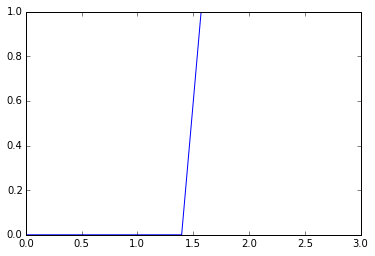

In [6]:
plt.plot(x_hist[:-1],y_hist)

In [ ]:
y_hist_items=[]
for x, y in zip(x_hist[:-1],y_hist):
    x = x * 180 / math.pi
    y_hist_items.extend([x+5] * int(y * 100))

## check layer by layer of model ##

In [186]:
model.get_config()

[{'class_name': 'Dense',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 22491),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dtype': u'float32',
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'RandomUniform',
    'config': {'maxval': 0.05, 'minval': -0.05, 'seed': None}},
   'kernel_regularizer': None,
   'name': u'dense_1',
   'trainable': True,
   'units': 1824,
   'use_bias': True}},
 {'class_name': 'Dropout',
  'config': {'name': u'dropout_1', 'rate': 0.4, 'trainable': True}},
 {'class_name': 'Dense',
  'config': {'activation': 'softplus',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'RandomUniform',
    'config': {'maxval': 0.05, 'minval': -0.05, 'seed': No

In [187]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1824)              41025408  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1824)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 612)               1116900   
_________________________________________________________________
dropout_2 (Dropout)          (None, 612)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 613       
Total params: 42,142,921
Trainable params: 42,142,921
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.layers[0].count_params() # = (22491 + 1) * 1824

41025408

In [4]:
dir(model.layers[-1])

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_inbound_node',
 '_built',
 '_constraints',
 '_get_node_attribute_at_index',
 '_initial_weights',
 '_losses',
 '_non_trainable_weights',
 '_per_input_losses',
 '_per_input_updates',
 '_trainable_weights',
 '_updates',
 'activation',
 'activity_regularizer',
 'add_loss',
 'add_update',
 'add_weight',
 'assert_input_compatibility',
 'bias',
 'bias_constraint',
 'bias_initializer',
 'bias_regularizer',
 'build',
 'built',
 'call',
 'compute_mask',
 'compute_output_shape',
 'constraints',
 'count_params',
 'from_config',
 'get_config',
 'get_input_at',
 'get_input_mask_at',
 'get_input_shape_at',
 'get_losses_for',
 'get_output_at',
 'get_output_mask_at',
 'get_output_shape_at',
 'get_updates_for',
 'get_w

In [7]:
map(lambda x: x.name, model.layers)

[u'dense_1', u'dropout_1', u'dense_2', u'dropout_2', u'dense_3']

In [8]:
model.input

/dense_1_input

In [165]:
# from: https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function( [inp]+[K.learning_phase()], [out] ) for out in outputs]  # evaluation functions

# Testing
at = 3
test_input = np.array(map(np.ndarray.flatten, jkutils.preprocess(input_data[0][test_inds[0][0]+at:test_inds[0][0]+at+1],
                                                                        inf_times_as)))
test_output = out_data[i][test_inds[i][0]+at:test_inds[i][0]+at+1,zenith:zenith+1]
print "soll - output:", jkutils.zenith_to_binary(test_output)
layer_outs = [func([test_input, 0.]) for func in functors] #wenn man hier 1. nutzt, hat der dropout_2_out einige nullen drin
print len(layer_outs)
print map(lambda l: l[0].shape, layer_outs)

soll - output: [[ 1.]]
5
[(1, 1824), (1, 1824), (1, 612), (1, 612), (1, 1)]


In [189]:
layer_outs[-1][0]

array([[ 1.]], dtype=float32)

In [166]:
dense_2_out = layer_outs[2][0]
dropout_2_out = layer_outs[3][0]

In [167]:
dense_3_weights = model.layers[-1].weights[0].get_value()
dense_3_bias = model.layers[-1].weights[1].get_value()
print dense_3_weights.shape, dense_3_bias.shape, dense_3_bias

(612, 1) (1,) [ 0.]


In [199]:
result = np.dot(dropout_2_out, dense_3_weights) + dense_3_bias
print result

[[-11.78538132]]


In [173]:
["{:9.6f}, {:9.6f}, {:9.6f}".format(a1,a2,a3) for a1,a2,a3 in zip(dense_2_out.flatten(), dropout_2_out.flatten(), dense_3_weights.flatten())]

[' 0.014400,  0.014400,  0.053651',
 ' 6.203943,  6.203943, -0.091842',
 ' 2.692855,  2.692855, -0.086770',
 ' 0.197846,  0.197846, -0.043562',
 ' 2.901987,  2.901987, -0.075306',
 ' 0.191179,  0.191179,  0.098602',
 ' 0.000877,  0.000877,  0.028599',
 ' 0.032002,  0.032002, -0.044400',
 ' 4.572266,  4.572266, -0.062611',
 ' 3.979314,  3.979314, -0.077654',
 ' 2.923302,  2.923302,  0.078914',
 ' 2.034243,  2.034243, -0.056436',
 ' 0.091223,  0.091223, -0.066727',
 ' 7.133690,  7.133690,  0.076272',
 ' 0.112093,  0.112093,  0.008658',
 ' 0.243567,  0.243567, -0.037307',
 ' 1.346752,  1.346752, -0.057693',
 ' 2.563497,  2.563497,  0.033620',
 ' 0.627499,  0.627499,  0.094319',
 ' 0.000150,  0.000150, -0.084867',
 ' 0.671689,  0.671689, -0.048711',
 ' 1.080560,  1.080560, -0.017200',
 ' 0.020565,  0.020565, -0.049517',
 ' 0.019892,  0.019892,  0.070909',
 ' 2.158415,  2.158415,  0.079493',
 ' 0.482144,  0.482144,  0.041563',
 ' 0.022038,  0.022038,  0.067173',
 ' 1.526759,  1.526759,  0.0

In [164]:
all((dense_2_out == dropout_2_out).flatten())

True

(1824,) 
-------------------
(1824,) 
-------------------
(612,) 
-------------------
(612,) 
-------------------
(1,) 
-------------------


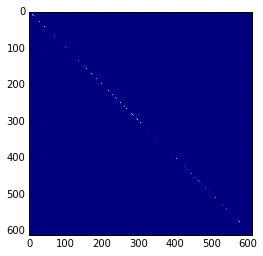

In [185]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras import backend as K

def get_layer_outputs():
    at = 3
    test_image = np.array(map(np.ndarray.flatten, jkutils.preprocess(input_data[0][test_inds[0][0]+at:test_inds[0][0]+at+1],
                                                                        inf_times_as)))
    outputs    = [layer.output for layer in model.layers]          # all layer outputs
    comp_graph = [K.function([model.input]+ [K.learning_phase()], [output]) for output in outputs]  # evaluation functions

    # Testing
    layer_outputs_list = [op([test_image, 1.]) for op in comp_graph]
    layer_outputs = []

    for layer_output in layer_outputs_list:
        print layer_output[0][0].shape,'\n-------------------'
        layer_outputs.append(layer_output[0][0])

    return layer_outputs

def plot_layer_outputs(layer_number):    
    layer_outputs = get_layer_outputs()

    x_max = layer_outputs[layer_number].shape[0]
    y_max = 1 # layer_outputs[layer_number].shape[1]
    n     = 1 # layer_outputs[layer_number].shape[2]

    L = []
    for i in range(n):
        L.append(np.zeros((x_max, x_max)))

    for i in range(n):
        for x in range(x_max):
            for y in range(y_max):
                L[i][x][x] = layer_outputs[layer_number][x]


    for img in L:
        plt.figure()
        plt.imshow(img, interpolation='nearest')
        
plot_layer_outputs(3)

this below is just a second cell[22] when I want to open another project simultaneously

In [3]:
file_location = '/data/user/jkager/NN_Reco/johannes/updownclassification_2/'
data_location = '/data/user/jkager/NN_Reco/'

today = '2017-07-31'
project_name = 'time1_h012_v1_w2do'

project_folder = 'train_hist/{}/{}'.format(today, project_name)
print "looking for", project_folder
if not os.path.exists('{}'.format(os.path.join(file_location,project_folder))):
    print "project not found. exiting..."
    sys.exit(-1)
shelf = shelve.open(os.path.join(file_location, project_folder, 'run_info.shlf'))
input_files = shelf['Files']
train_inds = shelf['Train_Inds'] 
valid_inds = shelf['Valid_Inds']
test_inds = shelf['Test_Inds']
inf_times_as = shelf['inf_times_as']
shelf.close()

input_data, out_data, file_len = jkutils.read_files(input_files.split(':'), data_location)
print('\n Load the Model (final_network.h5) \n')
model = load_model(os.path.join(\
file_location,'train_hist/{}/{}/final_network.h5'.format(today, project_name)))

print('\n Calculate Results... \n')
res = []
test_out = []

for i in range(len(input_data)):
    print('Predict Values for {}'.format(input_files.split(':')[i]))
    test_in_chunk  = np.array(map(np.ndarray.flatten, jkutils.preprocess(input_data[i][test_inds[i][0]:test_inds[i][1]],
                                                                        inf_times_as)))
    test_out_chunk = out_data[i][test_inds[i][0]:test_inds[i][1],zenith:zenith+1]
    res_chunk = model.predict(test_in_chunk, verbose=3)
    res.extend(list(res_chunk))
    test_out.extend(list(test_out_chunk))

res = np.squeeze(res)
test_out = np.squeeze(test_out)
p = test_out.argsort() # sort zeniths
res = res[p]
test_out = test_out[p]
correct = np.sum(res == jkutils.zenith_to_binary(test_out))
total = len(res)
print "{} / {} = {:6.2f}%".format(correct, total, float(correct)/total*100)

looking for train_hist/2017-07-31/time1_h012_v1_w2do

 Load the Model (final_network.h5) 


 Calculate Results... 

Predict Values for 11069_00000-00999.h5
Predict Values for 11069_01000-01999.h5
Predict Values for 11069_02000-02999.h5
30797 / 56971 =  54.06%


In [ ]:
test_out

# analyze test_results

In [29]:
file_location = '/data/user/jkager/NN_Reco/johannes/updownclassification_2/'
data_location = '/data/user/jkager/NN_Reco/'

today = '2017-08-03'
project_name = 'test_outzero_linout'
file_name = 'test_results.npy'

project_folder = 'train_hist/{}/{}'.format(today, project_name)
print "looking for", project_folder
if not os.path.exists(os.path.join(file_location,project_folder)):
    print "project not found. exiting..."
    sys.exit(-1)
elif not os.path.exists(os.path.join(file_location, project_folder, file_name)):
    print "file not found. exiting..."
    sys.exit(-1)
print "found"
test_results = np.load(os.path.join(file_location, project_folder, file_name))

looking for train_hist/2017-08-03/test_outzero_linout
found


In [30]:
true_pos, true_neg = 0, 0
false_pos, false_neg = 0, 0
reals, preds = [], []
for pred, real in zip(test_results[0], test_results[1]):
    if real == 1:
        if pred < 0.5:
            false_neg += 1
        else:
            true_pos += 1
    if real == 0:
        if pred > 0.5:
            false_pos += 1
        else:
            true_neg += 1
    reals.append(real)
    preds.append(pred)

In [31]:
print "         |    pos    |    neg    "
print "---------+-----------+-----------"
sum_all = true_pos + false_pos + true_neg + false_neg
if sum_all == 0:
    print "no data"
print "test pos |{:10.2f}%|{:10.2f}%".format(100 * true_pos / float(sum_all), 100 * false_pos / float(sum_all))
print "test neg |{:10.2f}%|{:10.2f}%".format(100 * false_neg / float(sum_all), 100 * true_neg / float(sum_all))


print "---------+-----------+-----------\n"*2,    
print "         |    pos    |    neg    "
print "---------+-----------+-----------" 
print "test pos |{:11.0f}|{:11.0f}".format(100 * true_pos, 100 * false_pos)
print "test neg |{:11.0f}|{:11.0f}".format(100 * false_neg, 100 * true_neg)

         |    pos    |    neg    
---------+-----------+-----------
test pos |      0.00%|      0.00%
test neg |     54.88%|     45.12%
---------+-----------+-----------
---------+-----------+-----------
         |    pos    |    neg    
---------+-----------+-----------
test pos |          0|          0
test neg |    1033900|     850200


In [32]:
print "\n".join(map(str, zip(reals, preds)))

(1.0, -21991.33203125)
(1.0, -21784.86328125)
(1.0, -21886.4765625)
(1.0, -21961.880859375)
(0.0, -21789.328125)
(1.0, -21973.3046875)
(0.0, -21874.9140625)
(1.0, -21946.8359375)
(0.0, -21912.76171875)
(0.0, -21612.861328125)
(0.0, -21828.984375)
(1.0, -21833.93359375)
(1.0, -21985.94140625)
(1.0, -21934.361328125)
(1.0, -21966.3828125)
(1.0, -21752.916015625)
(0.0, -21573.42578125)
(1.0, -21834.072265625)
(1.0, -21984.68359375)
(0.0, -21703.345703125)
(0.0, -21944.64453125)
(1.0, -21918.4921875)
(1.0, -21912.046875)
(1.0, -21984.21875)
(1.0, -21948.578125)
(1.0, -21986.53515625)
(1.0, -21969.38671875)
(1.0, -21940.181640625)
(0.0, -21733.806640625)
(1.0, -21897.96484375)
(1.0, -21861.896484375)
(1.0, -21984.498046875)
(0.0, -21621.880859375)
(0.0, -21768.099609375)
(1.0, -21717.27734375)
(0.0, -21974.787109375)
(1.0, -21994.0703125)
(0.0, -21610.470703125)
(1.0, -21778.32421875)
(0.0, -21937.71875)
(1.0, -21997.431640625)
(1.0, -21730.517578125)
(0.0, -21802.810546875)
(1.0, -21994.97

## last activation function as linout to see what the outputs are

In [15]:
file_location = '/data/user/jkager/NN_Reco/johannes/updownclassification_2/'
data_location = '/data/user/jkager/NN_Reco/'

today = '2017-07-30'
project_name = 'time10_h0_v1_linout'

project_folder = 'train_hist/{}/{}'.format(today, project_name)
print "looking for", project_folder
if not os.path.exists('{}'.format(os.path.join(file_location,project_folder))):
    print "project not found. exiting..."
    sys.exit(-1)

looking for train_hist/2017-07-30/time10_h0_v1_linout


In [16]:
test_results = np.load(os.path.join(project_folder, 'test_results.npy'))

In [17]:
for pred, real in zip(test_results[0], test_results[1]):
    print real, pred

1.0 65543.0546875
1.0 64762.3398438
1.0 65106.0507812
1.0 65384.328125
0.0 64725.1835938
1.0 65454.0351562
0.0 65085.5273438
1.0 65336.6484375
0.0 65218.7851562
0.0 64109.1054688
0.0 64980.9101562
1.0 64911.8242188
1.0 65517.2382812
1.0 65255.9023438
1.0 65441.6445312
1.0 64516.2109375
0.0 63926.1640625
1.0 64926.2929688
1.0 65500.390625
0.0 64425.2460938
0.0 65362.3242188
1.0 65313.4101562
1.0 65203.2539062
1.0 65492.7851562
1.0 65361.5351562
1.0 65497.6367188
1.0 65392.8476562
1.0 65255.6445312
0.0 64625.703125
1.0 65258.4882812
1.0 65023.2421875
1.0 65478.3007812
0.0 64074.6640625
0.0 64670.8671875
1.0 64478.7773438
0.0 65449.6132812
1.0 65536.859375
0.0 64226.0117188
1.0 64739.5429688
0.0 65335.7109375
1.0 65542.1328125
1.0 64529.84375
0.0 64474.7734375
1.0 65555.4375
0.0 65109.4257812
1.0 65504.7070312
1.0 65115.2460938
1.0 65435.4765625
1.0 65072.0625
1.0 65504.2578125
1.0 65260.0976562
1.0 65447.2226562
1.0 65398.671875
1.0 65454.7851562
0.0 65019.9453125
1.0 65527.390625
0.0 64